<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Visualizing a Fingerprint-Based Model

For some problems, there is a natural hypothesis about the relevance of some physicochemical descriptors, so a model is built using these descriptors. For other problems, there may be some relevant structural alerts, and so there is a natural fingerprint-based model. We have seen other cases where a fingerprint-based approach is powerful. Now let's look at ways to interpret the predictions of these models. 

We will use our [Support Vector Classifier](SVC.ipynb).

In [1]:
import sys
import math, random
import numpy
sys.path.append('../../lib/')
import pandas  
import pickle
import Kernel

from sklearn import svm
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
from rdkit.Chem import Draw, AllChem
import pandas as pd

import matplotlib.pyplot as plt
'imported'

'imported'

## Read in the data

In [3]:
with open( "../../model_data/chembl21_drug_easy_gm_train.p", 'rb' ) as f:  
    (training_fp, training_gm, training_y, test_fp, 
     test_gm, test_y, training_name, training_drug, training_molecule, test_molecule) = pickle.load( f )


## The model



In [4]:
#from sklearn.svm import NuSVC

model = svm.NuSVC(kernel='precomputed',  
                nu=0.3,  
                verbose=True
) 
model.fit(
        training_gm,
        training_y,  # dependent values, to be predicted
        # could supply sample_weight
)
predicted = model.predict(test_gm)
accuracy_score(test_y, predicted)

[LibSVM]

0.7964026023727516

We saw [before](SVC.ipynb) that this classifier successfully recognises a small number of drugs, but then also sees as druglike a group which are mostly non-drugs. Let's find the top misclassified non-drugs in the training set.

0                                                                                                                          1
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       <img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAMgAAADICAIAAAAiOjnJAAAABmJLR0QA/wD/AP+gvaeTAAAdB0lEQVR4nO2deViTx/bHTxKSIIqYsGiBoHABLeIVRVooQgFRUaF1KXWDUlulrT7i1avF9YJrsbcqVH1cWqvoLSq4FMS6gdVSWcpSqygqICBEFNllJ8n8/hibXwohQvKORpzP06dPfN93Zk7gy7wzZ86cYSGEgEJhGvbLNoDSO6HCohCBCotCBCosChGosChEoMKiEIEKi0IEKiwKEaiwKESgwqIQgQqLQgQqLAoRqLAoRKDCohCBCotCBCosChGosChEoMKiEIEKi0IEKiwKEaiwKESgwqIQgQqLQgQqLAoRqLAoRKDCohCBCotCBCosChGosChEoMKiEIEKi0IEKiwKEaiwKESgwqIQgQqLQgQqLAoRqLAoRKDCohCBCotCBCosChGosChEoMKiEIEKi0IEKiwKEaiwKES
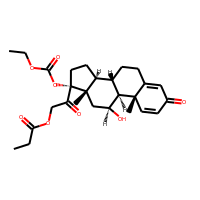
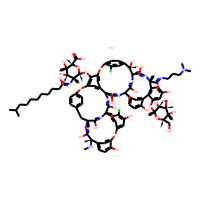
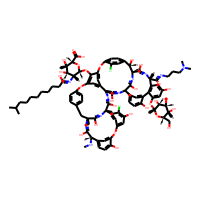
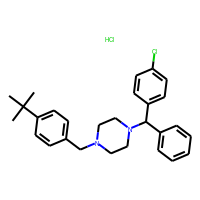
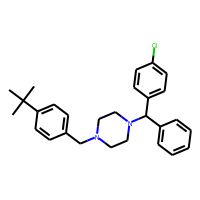
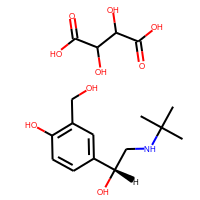
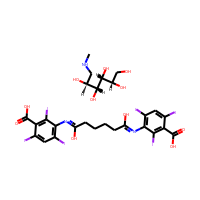
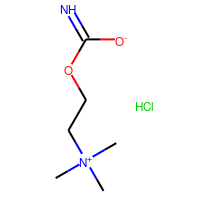
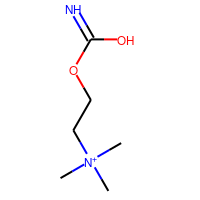
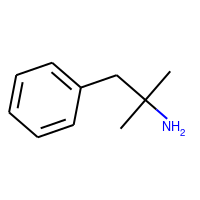
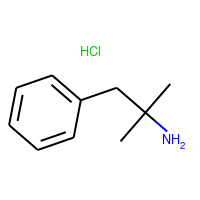
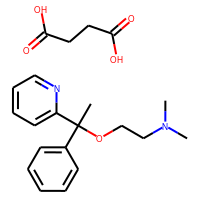

In [5]:
# above, the RDKit molecule objects are displayed poorly
# Now, use some magic
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)

from rdkit.Chem.Draw import IPythonConsole
#import os

training_scores = model.decision_function(training_gm)

# highest scoring first first
indices = numpy.flip(numpy.argsort(training_scores), axis=0 )
nondrug_indices = [i for  i in indices if training_drug.iloc[i]]

misclassified = []
for i in nondrug_indices[0:12]:
    misclassified.append( (
        training_molecule.iloc[i],
        '<a target="_new" href="https://pubchem.ncbi.nlm.nih.gov/compound/{0}">{0}</a>'.format(training_name.iloc[i])
    ))
pandas.DataFrame(misclassified)


The Support Vector Machine is stochastic, so you might get a different list.


<div class="alert alert-warning" role="alert">
**Exercise:** Follow the links. Which of these molecules are correctly classified as drug-like, and which should be considered as classification errors? </div>

Let's pick one of them and investigate. First, let's find the contribution of each atom to the prediction. First, we calculate a variant fingerprint, with the atom concerned removed. Then we see the prediction for this fingerprint.

In [6]:
import copy
from rdkit import DataStructs
from rdkit.Chem.Draw import SimilarityMaps
import copy
from rdkit.Chem.Draw import SimilarityMaps

# find index for our molecule
i = numpy.where( training_name =='LEVAMFETAMINE' )[0][0]
molecule = training_molecule.iloc[i]  
score = training_scores[i]  

# make variant fingerprints and score them
def get_atoms_scores(molecule, score):
    others = []
    for a in range(0,molecule.GetNumAtoms()):
        others.append( 
            Chem.Draw.SimilarityMaps.GetRDKFingerprint(molecule, maxPath=3, atomId=a)
        )

    # make gram matrix
    gm = numpy.zeros([len(others), len(training_fp)], dtype=numpy.float64)  
    for i in range(0, len(others)):
        for j in range(0, len(training_fp)):
            gm[i, j] =  DataStructs.FingerprintSimilarity(others[i], training_fp.iloc[j], 
                metric=DataStructs.cDataStructs.TanimotoSimilarity)
    other_gm = numpy.array(gm, dtype=numpy.float64)
    'Done'

    # make variant fingerprints
    others = []
    for a in range(0,molecule.GetNumAtoms()):
        others.append( 
            Chem.Draw.SimilarityMaps.GetRDKFingerprint(molecule, maxPath=3, atomId=a)
        )

    # make gram matrix
    gm = numpy.zeros([len(others), len(training_fp)], dtype=numpy.float64)  
    for i in range(0, len(others)):
        for j in range(0, len(training_fp)):
            gm[i, j] =  DataStructs.FingerprintSimilarity(others[i], training_fp.iloc[j], 
                metric=DataStructs.cDataStructs.TanimotoSimilarity)
    other_gm = numpy.array(gm, dtype=numpy.float64)
    return other_gm
'Done'

'Done'

## Highlight the atoms
Blue will mean most drug-like, red means least drug-like. We will choose a background colour corresponding to the score of the molecule as a whole, and highlight each atom according to its contribution. 

In [7]:
import matplotlib 
from IPython.display import SVG
IPythonConsole.ipython_useSVG=True


def getAtomContributions(molecule, score):
    other_gm = get_atoms_scores(molecule, score)

    # for each atom, this is the score without that atom
    other_score = model.decision_function(other_gm)
    # we calculate:
    offset =  sum(other_score)/molecule.GetNumAtoms() + score
    contributions = list(map(lambda s: offset-s, other_score))
    assert abs(sum(contributions)/molecule.GetNumAtoms()  - score) < 1e-10

    #contributions = [{} ]# dictionary of (atom, contribution) pairs  
    #for a in range(0,molecule.GetNumAtoms()):
    #    contrib[a] = contribution[a] # plt.cm.cool(scale(contribution[a] )) 
    return contributions
    
#cmap= matplotlib.colors.LinearSegmentedColormap.from_list('decision', [
#   (0, [1,0,0]),  (1, [0,0,1])
#])



In [8]:
highlightAtomColours = None
getAtomContributions(molecule, score)

[1.416222596611373,
 0.7838268131864072,
 0.824125244125246,
 0.824125244125246,
 1.2165114420473664,
 1.2165114420473664,
 1.483779816287771,
 0.7723124737277807,
 1.418909940775619,
 0.6214377780069227,
 0.3841782997862828]

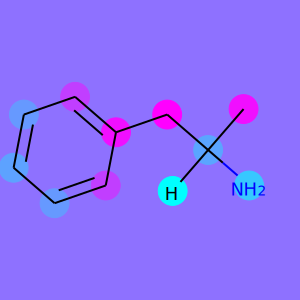

In [9]:
#molecule = Chem.MolFromInchi(inchi, sanitize=True)
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
def draw(mol,size=(300,300),kekulize=True, highlightAtomColors={}, background=(1.0, 1.0, 1.0)):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    drawer.drawOptions().setBackgroundColour( background )
    drawer.DrawMolecule(mc, highlightBonds=[],
        highlightAtoms=highlightAtomColors.keys(), highlightAtomColors=highlightAtomColors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    return SVG(svg.replace('svg:',''))

contributions  = getAtomContributions(molecule, score)
scale = matplotlib.colors.Normalize(min(contributions+[score]), max(contributions+[score]))  
highlightMap = {}
for j in range(0, len(contributions)):
    highlightMap[j] = plt.cm.cool(scale( contributions[j] ))

display(draw(molecule,  highlightAtomColors=highlightMap, background=plt.cm.cool(scale( score )) ))


## Compare with neighbours
In a [previous page](Fingerprint-Nearest.ipynb) we mapped the neighbourhood of this molecule. Now let's make this map for the neighbours.

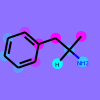

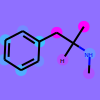

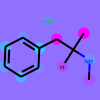

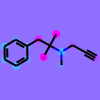

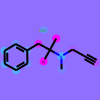

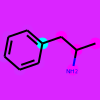

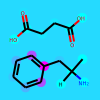

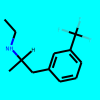

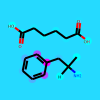

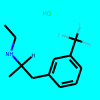

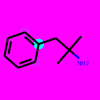

In [10]:
from IPython.core.display import HTML

neighbours_matrix = pickle.load( open( "../../model_data/neighbours.pkl", "rb" ) )
i = numpy.where( training_name =='LEVAMFETAMINE' )[0][0]
neighbours = training_molecule.iloc[ list( neighbours_matrix[i] ) ]
scores = training_scores[list( neighbours_matrix[i] )] 
all_contributions = []
for m, s in zip(neighbours, scores):
    all_contributions.append( getAtomContributions(m, s) )
## scale = matplotlib.colors.Normalize(min(other_score), max(other_score))

for m, s, cs in zip(neighbours, scores, all_contributions):    
    highlightMap = {} # dictionary of (atom, color) pairs  
    for a in range(0,m.GetNumAtoms()):
        highlightMap[a] = plt.cm.cool(scale(cs[a] ))
    display(
        draw(m, size=(100,100),  
             highlightAtomColors=highlightMap, background=plt.cm.cool(scale( s )) 
        ) 
    )
    


<div class="alert alert-warning" role="alert">
** Exercise:** Try with a different fingerprint. Is the prediction stronger or weaker? Do the images make more or less chemical sense? <br>
** Advanced Exercise: ** Lay out these figures in a table using [svgutils](https://svgutils.readthedocs.io/en/latest/tutorials/composing_multipanel_figures.html). </div>

## Further reading
- [Polishchuk, Interpretation of Quantitative Structure–Activity Relationship Models: Past, Present, and Future](http://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00274)
- [Riniker and Landrum, *Similarity maps - a visualization strategy for molecular fingerprints and machine-learning methods*](https://link.springer.com/article/10.1186/1758-2946-5-43)

[Up](../Welcome.ipynb) [Support Vector Classifier](SVC.ipynb) [Support Vector Regression](SVR.ipynb)
[Next](CombinedModels.ipynb)


Copyright STFC 2018